<a href="https://colab.research.google.com/github/bibird0112/Transformer_vision_for_classification/blob/main/VisionTransformer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import math
import copy
import numpy as np
from tqdm import tqdm
import PIL as Image


# Training
import torchvision.utils as vutils
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torch.amp import autocast, GradScaler

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.n_heads = n_heads # Number of attention heads
        self.d_k = d_model // n_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):

        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask) # TODO : faut il un mask ?

        output = self.W_o(self.combine_heads(attn_output)) # TODO : expliquer si il faut un biais ou non

        return output

class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_channels = n_channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  def forward(self, x):

    x = self.linear_project(x)
    x = x.flatten(2)
    x = x.transpose(1, 2)

    return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        # Learnable CLS token for classification [1, 1, d_model]
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Create position indices: [0, 1, 2, ..., max_seq_length-1] → [max_seq_length, 1]
        position = torch.arange(max_seq_length).unsqueeze(1)

        # Compute frequency terms: [1, 10000^(-2/d), 10000^(-4/d), ..., 10000^(-(d-2)/d)]
        # Different frequencies for different dimensions → [d_model//2]
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # Initialize positional encoding matrix [max_seq_length, d_model]
        pe = torch.zeros(max_seq_length, d_model)

        # Even dimensions (0, 2, 4, ...): use sine
        # PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)

        # Odd dimensions (1, 3, 5, ...): use cosine
        # PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (saved but not trained) → [1, max_seq_length, d_model]
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [batch_size, num_patches, d_model]

        # Expand CLS token for the whole batch → [batch_size, 1, d_model]
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Prepend CLS token: [batch_size, num_patches+1, d_model]
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding (truncated to sequence length)
        x = x + self.pe[:, :x.size(1)]

        return x  # [batch_size, num_patches+1, d_model]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential( # Feed-Forward Networks
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * r_mlp, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x_norm = self.ln1(x)
        attn_out = self.dropout1(self.mha(x_norm, x_norm, x_norm))
        x = x + attn_out

        x_norm = self.ln2(x)
        mlp_out = self.mlp(x_norm)
        x = x + mlp_out
        return x


class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])

    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)

    self.positional_encoding = PositionalEncoding( self.d_model, self.max_seq_length)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoder( self.d_model, self.n_heads) for _ in range(n_layers)])

    self.norm = nn.LayerNorm(self.d_model)
    # Classification MLP
    self.classifier = nn.Linear(self.d_model, self.n_classes)

  def forward(self, images):

    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)

    x = self.norm(x)

    x = self.classifier(x[:,0])

    return x

In [ ]:
# ============================================
# OPTIMISED HYPERPARAMETERS
# ============================================

# Architecture
d_model = 192
n_classes = 10
img_size = (32, 32)
patch_size = (8, 8)
n_channels = 3
n_heads = 6
n_layers = 8
dropout = 0.2

# Training
batch_size = 256
epochs = 200
base_lr = 5e-4
weight_decay = 0.05
warmup_epochs = 10
label_smoothing = 0.1

# Validation split
val_split = 0.1        # 10% of the dataset for validation -> used in earlystopping

# ============================================
# DATA AUGMENTATION & PREPROCESSING
# ============================================

# Strong augmentation for training
train_transform = T.Compose([
    T.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    T.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

# Simple transform for validation/test
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# ============================================
# DATASET & DATALOADERS
# ============================================
full_train_set = CIFAR10(
    root="./../datasets", train=True, download=True, transform=train_transform
)

test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=test_transform
)

# Split train/validation
train_size = int((1 - val_split) * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(
    full_train_set,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproductibility
)


val_dataset = CIFAR10(
    root="./../datasets", train=True, download=False, transform=test_transform
)
val_dataset.data = val_dataset.data[val_set.indices]
val_dataset.targets = [val_dataset.targets[i] for i in val_set.indices]

# DataLoaders
train_loader = DataLoader(
    train_set, shuffle=True, batch_size=batch_size,
    num_workers=4, pin_memory=True, drop_last=True
)

val_loader = DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size,
    num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_set, shuffle=False, batch_size=batch_size,
    num_workers=4, pin_memory=True
)


Using device: cuda (NVIDIA A100-SXM4-40GB)
Memory available: 42.47 GB

Initializing Vision Transformer:
  - Patches: 16
  - Model dimension: 192
  - Heads: 6
  - Layers: 8
  - Parameters: ~1.2M (approx)
  - Total parameters: 3,598,474
  - Trainable parameters: 3,598,474

STARTING TRAINING

[Epoch 1/200]


/tmp/ipython-input-2358451422.py:342: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax_val.set_ylim(min(loss_gap) * 1.2, max(loss_gap) * 1.2)


  Train Loss: 2.2066 | Train Acc: 18.64%
  Val Loss:   1.9859 | Val Acc:   31.58%
  Learning Rate: 5.00e-05
 New best model saved! (Val Acc: 31.58%)

[Epoch 2/200]


  Train Loss: 2.0238 | Train Acc: 28.32%
  Val Loss:   1.8239 | Val Acc:   38.84%
  Learning Rate: 1.00e-04
 New best model saved! (Val Acc: 38.84%)

[Epoch 3/200]


  Train Loss: 1.9140 | Train Acc: 34.16%
  Val Loss:   1.7165 | Val Acc:   44.92%
  Learning Rate: 1.50e-04
 New best model saved! (Val Acc: 44.92%)

[Epoch 4/200]


  Train Loss: 1.8421 | Train Acc: 37.63%
  Val Loss:   1.6342 | Val Acc:   47.64%
  Learning Rate: 2.00e-04
 New best model saved! (Val Acc: 47.64%)

[Epoch 5/200]


  Train Loss: 1.7780 | Train Acc: 40.33%
  Val Loss:   1.5899 | Val Acc:   50.54%
  Learning Rate: 2.50e-04
 New best model saved! (Val Acc: 50.54%)

[Epoch 6/200]


  Train Loss: 1.7383 | Train Acc: 42.88%
  Val Loss:   1.5098 | Val Acc:   53.44%
  Learning Rate: 3.00e-04
 New best model saved! (Val Acc: 53.44%)

[Epoch 7/200]


  Train Loss: 1.7012 | Train Acc: 44.67%
  Val Loss:   1.4825 | Val Acc:   55.08%
  Learning Rate: 3.50e-04
 New best model saved! (Val Acc: 55.08%)

[Epoch 8/200]


  Train Loss: 1.6705 | Train Acc: 46.03%
  Val Loss:   1.4733 | Val Acc:   55.90%
  Learning Rate: 4.00e-04
 New best model saved! (Val Acc: 55.90%)

[Epoch 9/200]


  Train Loss: 1.6449 | Train Acc: 47.19%
  Val Loss:   1.4313 | Val Acc:   57.52%
  Learning Rate: 4.50e-04
 New best model saved! (Val Acc: 57.52%)

[Epoch 10/200]


  Train Loss: 1.6200 | Train Acc: 48.50%
  Val Loss:   1.4547 | Val Acc:   54.82%
  Learning Rate: 5.00e-04


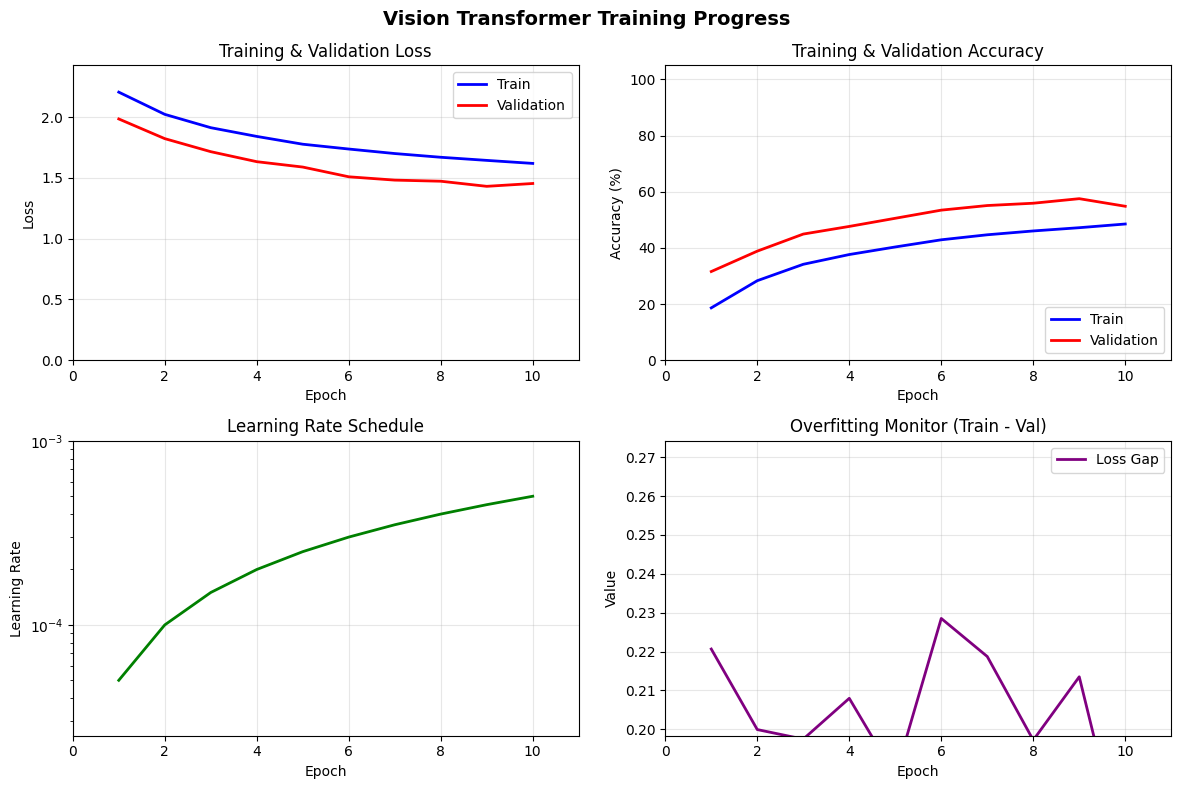


[Epoch 11/200]


  Train Loss: 1.5973 | Train Acc: 49.69%
  Val Loss:   1.4138 | Val Acc:   58.58%
  Learning Rate: 5.00e-04
 New best model saved! (Val Acc: 58.58%)

[Epoch 12/200]


  Train Loss: 1.5720 | Train Acc: 50.76%
  Val Loss:   1.3732 | Val Acc:   61.40%
  Learning Rate: 5.00e-04
 New best model saved! (Val Acc: 61.40%)

[Epoch 13/200]


  Train Loss: 1.5459 | Train Acc: 52.24%
  Val Loss:   1.3448 | Val Acc:   61.78%
  Learning Rate: 5.00e-04
 New best model saved! (Val Acc: 61.78%)

[Epoch 14/200]


  Train Loss: 1.5211 | Train Acc: 53.27%
  Val Loss:   1.3466 | Val Acc:   61.86%
  Learning Rate: 4.99e-04
 New best model saved! (Val Acc: 61.86%)

[Epoch 15/200]


  Train Loss: 1.4975 | Train Acc: 54.40%
  Val Loss:   1.3164 | Val Acc:   62.98%
  Learning Rate: 4.99e-04
 New best model saved! (Val Acc: 62.98%)

[Epoch 16/200]


  Train Loss: 1.4743 | Train Acc: 55.52%
  Val Loss:   1.3235 | Val Acc:   62.60%
  Learning Rate: 4.99e-04

[Epoch 17/200]


  Train Loss: 1.4541 | Train Acc: 56.53%
  Val Loss:   1.2696 | Val Acc:   65.54%
  Learning Rate: 4.98e-04
 New best model saved! (Val Acc: 65.54%)

[Epoch 18/200]


  Train Loss: 1.4402 | Train Acc: 57.09%
  Val Loss:   1.2696 | Val Acc:   64.66%
  Learning Rate: 4.98e-04

[Epoch 19/200]


  Train Loss: 1.4220 | Train Acc: 58.21%
  Val Loss:   1.2234 | Val Acc:   66.94%
  Learning Rate: 4.97e-04
 New best model saved! (Val Acc: 66.94%)

[Epoch 20/200]


  Train Loss: 1.4079 | Train Acc: 58.47%
  Val Loss:   1.2150 | Val Acc:   67.78%
  Learning Rate: 4.97e-04
 New best model saved! (Val Acc: 67.78%)


<Figure size 640x480 with 0 Axes>


[Epoch 21/200]


  Train Loss: 1.3954 | Train Acc: 59.40%
  Val Loss:   1.2341 | Val Acc:   66.54%
  Learning Rate: 4.96e-04

[Epoch 22/200]


  Train Loss: 1.3769 | Train Acc: 60.19%
  Val Loss:   1.2119 | Val Acc:   67.72%
  Learning Rate: 4.95e-04

[Epoch 23/200]


  Train Loss: 1.3673 | Train Acc: 60.55%
  Val Loss:   1.2145 | Val Acc:   67.24%
  Learning Rate: 4.94e-04

[Epoch 24/200]


  Train Loss: 1.3553 | Train Acc: 61.14%
  Val Loss:   1.1868 | Val Acc:   68.62%
  Learning Rate: 4.93e-04
 New best model saved! (Val Acc: 68.62%)

[Epoch 25/200]


  Train Loss: 1.3433 | Train Acc: 61.80%
  Val Loss:   1.1771 | Val Acc:   69.80%
  Learning Rate: 4.92e-04
 New best model saved! (Val Acc: 69.80%)

[Epoch 26/200]


  Train Loss: 1.3224 | Train Acc: 62.77%
  Val Loss:   1.1676 | Val Acc:   69.92%
  Learning Rate: 4.91e-04
 New best model saved! (Val Acc: 69.92%)

[Epoch 27/200]


  Train Loss: 1.3171 | Train Acc: 63.07%
  Val Loss:   1.1556 | Val Acc:   70.30%
  Learning Rate: 4.90e-04
 New best model saved! (Val Acc: 70.30%)

[Epoch 28/200]


  Train Loss: 1.3067 | Train Acc: 63.15%
  Val Loss:   1.1665 | Val Acc:   70.04%
  Learning Rate: 4.89e-04

[Epoch 29/200]


  Train Loss: 1.2947 | Train Acc: 63.84%
  Val Loss:   1.1451 | Val Acc:   70.74%
  Learning Rate: 4.88e-04
 New best model saved! (Val Acc: 70.74%)

[Epoch 30/200]


  Train Loss: 1.2836 | Train Acc: 64.46%
  Val Loss:   1.1613 | Val Acc:   70.02%
  Learning Rate: 4.86e-04


<Figure size 640x480 with 0 Axes>


[Epoch 31/200]


  Train Loss: 1.2744 | Train Acc: 65.01%
  Val Loss:   1.1251 | Val Acc:   72.00%
  Learning Rate: 4.85e-04
 New best model saved! (Val Acc: 72.00%)

[Epoch 32/200]


  Train Loss: 1.2623 | Train Acc: 65.54%
  Val Loss:   1.1224 | Val Acc:   72.58%
  Learning Rate: 4.84e-04
 New best model saved! (Val Acc: 72.58%)

[Epoch 33/200]


  Train Loss: 1.2530 | Train Acc: 65.69%
  Val Loss:   1.1042 | Val Acc:   72.96%
  Learning Rate: 4.82e-04
 New best model saved! (Val Acc: 72.96%)

[Epoch 34/200]


  Train Loss: 1.2448 | Train Acc: 66.52%
  Val Loss:   1.0952 | Val Acc:   72.94%
  Learning Rate: 4.81e-04

[Epoch 35/200]


  Train Loss: 1.2312 | Train Acc: 66.98%
  Val Loss:   1.1044 | Val Acc:   72.92%
  Learning Rate: 4.79e-04

[Epoch 36/200]


  Train Loss: 1.2276 | Train Acc: 67.04%
  Val Loss:   1.0826 | Val Acc:   73.08%
  Learning Rate: 4.77e-04
 New best model saved! (Val Acc: 73.08%)

[Epoch 37/200]


  Train Loss: 1.2141 | Train Acc: 67.82%
  Val Loss:   1.0874 | Val Acc:   73.52%
  Learning Rate: 4.75e-04
 New best model saved! (Val Acc: 73.52%)

[Epoch 38/200]


  Train Loss: 1.2053 | Train Acc: 68.13%
  Val Loss:   1.0741 | Val Acc:   73.86%
  Learning Rate: 4.74e-04
 New best model saved! (Val Acc: 73.86%)

[Epoch 39/200]


  Train Loss: 1.1994 | Train Acc: 68.33%
  Val Loss:   1.0698 | Val Acc:   74.32%
  Learning Rate: 4.72e-04
 New best model saved! (Val Acc: 74.32%)

[Epoch 40/200]


  Train Loss: 1.1893 | Train Acc: 68.98%
  Val Loss:   1.0643 | Val Acc:   75.06%
  Learning Rate: 4.70e-04
 New best model saved! (Val Acc: 75.06%)


<Figure size 640x480 with 0 Axes>


[Epoch 41/200]


  Train Loss: 1.1849 | Train Acc: 68.90%
  Val Loss:   1.0569 | Val Acc:   74.92%
  Learning Rate: 4.68e-04

[Epoch 42/200]


  Train Loss: 1.1806 | Train Acc: 69.36%
  Val Loss:   1.0351 | Val Acc:   76.20%
  Learning Rate: 4.66e-04
 New best model saved! (Val Acc: 76.20%)

[Epoch 43/200]


  Train Loss: 1.1684 | Train Acc: 69.93%
  Val Loss:   1.0362 | Val Acc:   75.72%
  Learning Rate: 4.64e-04

[Epoch 44/200]


  Train Loss: 1.1628 | Train Acc: 70.09%
  Val Loss:   1.0466 | Val Acc:   75.46%
  Learning Rate: 4.62e-04

[Epoch 45/200]


  Train Loss: 1.1497 | Train Acc: 70.41%
  Val Loss:   1.0315 | Val Acc:   75.42%
  Learning Rate: 4.59e-04

[Epoch 46/200]


  Train Loss: 1.1497 | Train Acc: 70.81%
  Val Loss:   1.0326 | Val Acc:   76.66%
  Learning Rate: 4.57e-04
 New best model saved! (Val Acc: 76.66%)

[Epoch 47/200]


  Train Loss: 1.1408 | Train Acc: 71.09%
  Val Loss:   1.0453 | Val Acc:   75.14%
  Learning Rate: 4.55e-04

[Epoch 48/200]


  Train Loss: 1.1328 | Train Acc: 71.23%
  Val Loss:   1.0218 | Val Acc:   76.56%
  Learning Rate: 4.52e-04

[Epoch 49/200]


  Train Loss: 1.1281 | Train Acc: 71.70%
  Val Loss:   1.0505 | Val Acc:   75.82%
  Learning Rate: 4.50e-04

[Epoch 50/200]


  Train Loss: 1.1208 | Train Acc: 71.97%
  Val Loss:   1.0221 | Val Acc:   76.52%
  Learning Rate: 4.47e-04


<Figure size 640x480 with 0 Axes>


[Epoch 51/200]


  Train Loss: 1.1156 | Train Acc: 72.21%
  Val Loss:   1.0029 | Val Acc:   77.94%
  Learning Rate: 4.45e-04
 New best model saved! (Val Acc: 77.94%)

[Epoch 52/200]


  Train Loss: 1.1057 | Train Acc: 72.73%
  Val Loss:   1.0296 | Val Acc:   76.48%
  Learning Rate: 4.42e-04

[Epoch 53/200]


  Train Loss: 1.1025 | Train Acc: 72.86%
  Val Loss:   1.0096 | Val Acc:   76.92%
  Learning Rate: 4.39e-04

[Epoch 54/200]


  Train Loss: 1.0944 | Train Acc: 73.15%
  Val Loss:   0.9894 | Val Acc:   78.14%
  Learning Rate: 4.37e-04
 New best model saved! (Val Acc: 78.14%)

[Epoch 55/200]


  Train Loss: 1.0937 | Train Acc: 73.36%
  Val Loss:   1.0111 | Val Acc:   77.14%
  Learning Rate: 4.34e-04

[Epoch 56/200]


  Train Loss: 1.0772 | Train Acc: 73.89%
  Val Loss:   1.0068 | Val Acc:   77.28%
  Learning Rate: 4.31e-04

[Epoch 57/200]


  Train Loss: 1.0823 | Train Acc: 73.70%
  Val Loss:   1.0039 | Val Acc:   77.48%
  Learning Rate: 4.28e-04

[Epoch 58/200]


  Train Loss: 1.0707 | Train Acc: 74.21%
  Val Loss:   0.9854 | Val Acc:   78.62%
  Learning Rate: 4.25e-04
 New best model saved! (Val Acc: 78.62%)

[Epoch 59/200]


  Train Loss: 1.0676 | Train Acc: 74.43%
  Val Loss:   1.0066 | Val Acc:   77.32%
  Learning Rate: 4.22e-04

[Epoch 60/200]


  Train Loss: 1.0673 | Train Acc: 74.47%
  Val Loss:   0.9964 | Val Acc:   77.36%
  Learning Rate: 4.19e-04


<Figure size 640x480 with 0 Axes>


[Epoch 61/200]


  Train Loss: 1.0527 | Train Acc: 75.12%
  Val Loss:   0.9778 | Val Acc:   78.62%
  Learning Rate: 4.16e-04

[Epoch 62/200]


  Train Loss: 1.0493 | Train Acc: 75.36%
  Val Loss:   0.9903 | Val Acc:   77.86%
  Learning Rate: 4.13e-04

[Epoch 63/200]


  Train Loss: 1.0491 | Train Acc: 75.31%
  Val Loss:   0.9976 | Val Acc:   78.38%
  Learning Rate: 4.10e-04

[Epoch 64/200]


  Train Loss: 1.0470 | Train Acc: 75.07%
  Val Loss:   0.9816 | Val Acc:   78.74%
  Learning Rate: 4.07e-04
 New best model saved! (Val Acc: 78.74%)

[Epoch 65/200]


  Train Loss: 1.0363 | Train Acc: 75.87%
  Val Loss:   0.9798 | Val Acc:   78.62%
  Learning Rate: 4.04e-04

[Epoch 66/200]


  Train Loss: 1.0330 | Train Acc: 76.13%
  Val Loss:   0.9873 | Val Acc:   78.86%
  Learning Rate: 4.00e-04
 New best model saved! (Val Acc: 78.86%)

[Epoch 67/200]


  Train Loss: 1.0302 | Train Acc: 76.27%
  Val Loss:   0.9794 | Val Acc:   78.90%
  Learning Rate: 3.97e-04
 New best model saved! (Val Acc: 78.90%)

[Epoch 68/200]


  Train Loss: 1.0265 | Train Acc: 76.31%
  Val Loss:   0.9667 | Val Acc:   79.30%
  Learning Rate: 3.94e-04
 New best model saved! (Val Acc: 79.30%)

[Epoch 69/200]


  Train Loss: 1.0211 | Train Acc: 76.49%
  Val Loss:   0.9584 | Val Acc:   79.92%
  Learning Rate: 3.90e-04
 New best model saved! (Val Acc: 79.92%)

[Epoch 70/200]


  Train Loss: 1.0122 | Train Acc: 77.09%
  Val Loss:   0.9737 | Val Acc:   79.10%
  Learning Rate: 3.87e-04


<Figure size 640x480 with 0 Axes>


[Epoch 71/200]


  Train Loss: 1.0103 | Train Acc: 77.09%
  Val Loss:   0.9703 | Val Acc:   79.58%
  Learning Rate: 3.83e-04

[Epoch 72/200]


  Train Loss: 0.9972 | Train Acc: 77.69%
  Val Loss:   0.9719 | Val Acc:   79.20%
  Learning Rate: 3.80e-04

[Epoch 73/200]


  Train Loss: 0.9996 | Train Acc: 77.45%
  Val Loss:   0.9779 | Val Acc:   78.76%
  Learning Rate: 3.76e-04

[Epoch 74/200]


  Train Loss: 0.9939 | Train Acc: 77.85%
  Val Loss:   0.9797 | Val Acc:   78.58%
  Learning Rate: 3.73e-04

[Epoch 75/200]


  Train Loss: 0.9900 | Train Acc: 78.13%
  Val Loss:   0.9674 | Val Acc:   79.26%
  Learning Rate: 3.69e-04

[Epoch 76/200]


  Train Loss: 0.9871 | Train Acc: 78.26%
  Val Loss:   0.9611 | Val Acc:   79.90%
  Learning Rate: 3.65e-04

[Epoch 77/200]


  Train Loss: 0.9810 | Train Acc: 78.50%
  Val Loss:   0.9527 | Val Acc:   80.22%
  Learning Rate: 3.62e-04
 New best model saved! (Val Acc: 80.22%)

[Epoch 78/200]


  Train Loss: 0.9732 | Train Acc: 78.83%
  Val Loss:   0.9563 | Val Acc:   79.64%
  Learning Rate: 3.58e-04

[Epoch 79/200]


  Train Loss: 0.9717 | Train Acc: 78.78%
  Val Loss:   0.9500 | Val Acc:   79.94%
  Learning Rate: 3.54e-04

[Epoch 80/200]


  Train Loss: 0.9691 | Train Acc: 78.78%
  Val Loss:   0.9637 | Val Acc:   79.68%
  Learning Rate: 3.50e-04


<Figure size 640x480 with 0 Axes>


[Epoch 81/200]


  Train Loss: 0.9618 | Train Acc: 79.33%
  Val Loss:   0.9546 | Val Acc:   80.04%
  Learning Rate: 3.47e-04

[Epoch 82/200]


  Train Loss: 0.9570 | Train Acc: 79.48%
  Val Loss:   0.9661 | Val Acc:   79.42%
  Learning Rate: 3.43e-04

[Epoch 83/200]


  Train Loss: 0.9527 | Train Acc: 79.67%
  Val Loss:   0.9374 | Val Acc:   80.98%
  Learning Rate: 3.39e-04
 New best model saved! (Val Acc: 80.98%)

[Epoch 84/200]


  Train Loss: 0.9497 | Train Acc: 79.91%
  Val Loss:   0.9482 | Val Acc:   80.42%
  Learning Rate: 3.35e-04

[Epoch 85/200]


  Train Loss: 0.9530 | Train Acc: 79.70%
  Val Loss:   0.9350 | Val Acc:   81.16%
  Learning Rate: 3.31e-04
 New best model saved! (Val Acc: 81.16%)

[Epoch 86/200]


  Train Loss: 0.9401 | Train Acc: 80.27%
  Val Loss:   0.9434 | Val Acc:   80.48%
  Learning Rate: 3.27e-04

[Epoch 87/200]


  Train Loss: 0.9326 | Train Acc: 80.63%
  Val Loss:   0.9409 | Val Acc:   81.42%
  Learning Rate: 3.23e-04
 New best model saved! (Val Acc: 81.42%)

[Epoch 88/200]


  Train Loss: 0.9380 | Train Acc: 80.40%
  Val Loss:   0.9479 | Val Acc:   81.00%
  Learning Rate: 3.19e-04

[Epoch 89/200]


  Train Loss: 0.9351 | Train Acc: 80.45%
  Val Loss:   0.9525 | Val Acc:   80.34%
  Learning Rate: 3.15e-04

[Epoch 90/200]


  Train Loss: 0.9302 | Train Acc: 80.86%
  Val Loss:   0.9400 | Val Acc:   80.60%
  Learning Rate: 3.11e-04


<Figure size 640x480 with 0 Axes>


[Epoch 91/200]


  Train Loss: 0.9200 | Train Acc: 81.50%
  Val Loss:   0.9381 | Val Acc:   81.24%
  Learning Rate: 3.07e-04

[Epoch 92/200]


  Train Loss: 0.9211 | Train Acc: 80.95%
  Val Loss:   0.9471 | Val Acc:   80.70%
  Learning Rate: 3.03e-04

[Epoch 93/200]


  Train Loss: 0.9223 | Train Acc: 80.94%
  Val Loss:   0.9386 | Val Acc:   81.64%
  Learning Rate: 2.99e-04
 New best model saved! (Val Acc: 81.64%)

[Epoch 94/200]


  Train Loss: 0.9152 | Train Acc: 81.32%
  Val Loss:   0.9412 | Val Acc:   81.28%
  Learning Rate: 2.95e-04

[Epoch 95/200]


  Train Loss: 0.9091 | Train Acc: 81.55%
  Val Loss:   0.9339 | Val Acc:   81.78%
  Learning Rate: 2.91e-04
 New best model saved! (Val Acc: 81.78%)

[Epoch 96/200]


  Train Loss: 0.9024 | Train Acc: 82.14%
  Val Loss:   0.9287 | Val Acc:   81.86%
  Learning Rate: 2.87e-04
 New best model saved! (Val Acc: 81.86%)

[Epoch 97/200]


  Train Loss: 0.8990 | Train Acc: 81.98%
  Val Loss:   0.9415 | Val Acc:   81.42%
  Learning Rate: 2.83e-04

[Epoch 98/200]


  Train Loss: 0.9026 | Train Acc: 81.93%
  Val Loss:   0.9377 | Val Acc:   81.56%
  Learning Rate: 2.79e-04

[Epoch 99/200]


  Train Loss: 0.9051 | Train Acc: 82.00%
  Val Loss:   0.9194 | Val Acc:   82.10%
  Learning Rate: 2.75e-04
 New best model saved! (Val Acc: 82.10%)

[Epoch 100/200]


  Train Loss: 0.8945 | Train Acc: 82.24%
  Val Loss:   0.9246 | Val Acc:   81.92%
  Learning Rate: 2.71e-04


<Figure size 640x480 with 0 Axes>


[Epoch 101/200]


  Train Loss: 0.8914 | Train Acc: 82.43%
  Val Loss:   0.9332 | Val Acc:   81.64%
  Learning Rate: 2.67e-04

[Epoch 102/200]


  Train Loss: 0.8824 | Train Acc: 83.05%
  Val Loss:   0.9315 | Val Acc:   81.66%
  Learning Rate: 2.62e-04

[Epoch 103/200]


  Train Loss: 0.8824 | Train Acc: 82.90%
  Val Loss:   0.9361 | Val Acc:   82.14%
  Learning Rate: 2.58e-04
 New best model saved! (Val Acc: 82.14%)

[Epoch 104/200]


  Train Loss: 0.8807 | Train Acc: 82.94%
  Val Loss:   0.9274 | Val Acc:   82.08%
  Learning Rate: 2.54e-04

[Epoch 105/200]


  Train Loss: 0.8758 | Train Acc: 83.33%
  Val Loss:   0.9252 | Val Acc:   81.94%
  Learning Rate: 2.50e-04

[Epoch 106/200]


  Train Loss: 0.8710 | Train Acc: 83.29%
  Val Loss:   0.9236 | Val Acc:   81.80%
  Learning Rate: 2.46e-04

[Epoch 107/200]


  Train Loss: 0.8680 | Train Acc: 83.61%
  Val Loss:   0.9276 | Val Acc:   82.16%
  Learning Rate: 2.42e-04
 New best model saved! (Val Acc: 82.16%)

[Epoch 108/200]


  Train Loss: 0.8654 | Train Acc: 83.60%
  Val Loss:   0.9293 | Val Acc:   81.72%
  Learning Rate: 2.38e-04

[Epoch 109/200]


  Train Loss: 0.8619 | Train Acc: 83.89%
  Val Loss:   0.9422 | Val Acc:   80.98%
  Learning Rate: 2.33e-04

[Epoch 110/200]


  Train Loss: 0.8574 | Train Acc: 84.04%
  Val Loss:   0.9279 | Val Acc:   82.10%
  Learning Rate: 2.29e-04


<Figure size 640x480 with 0 Axes>


[Epoch 111/200]


  Train Loss: 0.8602 | Train Acc: 83.87%
  Val Loss:   0.9113 | Val Acc:   82.90%
  Learning Rate: 2.25e-04
 New best model saved! (Val Acc: 82.90%)

[Epoch 112/200]


  Train Loss: 0.8530 | Train Acc: 84.37%
  Val Loss:   0.9256 | Val Acc:   81.86%
  Learning Rate: 2.21e-04

[Epoch 113/200]


  Train Loss: 0.8519 | Train Acc: 84.40%
  Val Loss:   0.9162 | Val Acc:   82.74%
  Learning Rate: 2.17e-04

[Epoch 114/200]


  Train Loss: 0.8476 | Train Acc: 84.49%
  Val Loss:   0.9128 | Val Acc:   82.64%
  Learning Rate: 2.13e-04

[Epoch 115/200]


  Train Loss: 0.8428 | Train Acc: 84.76%
  Val Loss:   0.9262 | Val Acc:   82.56%
  Learning Rate: 2.09e-04

[Epoch 116/200]


  Train Loss: 0.8408 | Train Acc: 84.86%
  Val Loss:   0.9171 | Val Acc:   82.56%
  Learning Rate: 2.05e-04

[Epoch 117/200]


  Train Loss: 0.8397 | Train Acc: 84.74%
  Val Loss:   0.9116 | Val Acc:   82.64%
  Learning Rate: 2.01e-04

[Epoch 118/200]


  Train Loss: 0.8343 | Train Acc: 85.11%
  Val Loss:   0.9181 | Val Acc:   82.70%
  Learning Rate: 1.97e-04

[Epoch 119/200]


  Train Loss: 0.8330 | Train Acc: 85.30%
  Val Loss:   0.9209 | Val Acc:   82.36%
  Learning Rate: 1.93e-04

[Epoch 120/200]


  Train Loss: 0.8344 | Train Acc: 85.00%
  Val Loss:   0.9206 | Val Acc:   82.06%
  Learning Rate: 1.89e-04


<Figure size 640x480 with 0 Axes>


[Epoch 121/200]


  Train Loss: 0.8317 | Train Acc: 85.27%
  Val Loss:   0.9138 | Val Acc:   82.52%
  Learning Rate: 1.85e-04

[Epoch 122/200]


  Train Loss: 0.8228 | Train Acc: 85.62%
  Val Loss:   0.9254 | Val Acc:   82.56%
  Learning Rate: 1.81e-04

[Epoch 123/200]


  Train Loss: 0.8193 | Train Acc: 85.77%
  Val Loss:   0.9319 | Val Acc:   82.26%
  Learning Rate: 1.77e-04

[Epoch 124/200]


  Train Loss: 0.8160 | Train Acc: 86.09%
  Val Loss:   0.9260 | Val Acc:   82.36%
  Learning Rate: 1.73e-04

[Epoch 125/200]


  Train Loss: 0.8181 | Train Acc: 85.87%
  Val Loss:   0.9178 | Val Acc:   83.00%
  Learning Rate: 1.69e-04
 New best model saved! (Val Acc: 83.00%)

[Epoch 126/200]


  Train Loss: 0.8144 | Train Acc: 86.07%
  Val Loss:   0.9257 | Val Acc:   82.38%
  Learning Rate: 1.65e-04

[Epoch 127/200]


  Train Loss: 0.8102 | Train Acc: 86.14%
  Val Loss:   0.9170 | Val Acc:   82.92%
  Learning Rate: 1.61e-04

[Epoch 128/200]


  Train Loss: 0.8152 | Train Acc: 85.87%
  Val Loss:   0.9203 | Val Acc:   82.28%
  Learning Rate: 1.57e-04

[Epoch 129/200]


  Train Loss: 0.8043 | Train Acc: 86.52%
  Val Loss:   0.9278 | Val Acc:   82.96%
  Learning Rate: 1.53e-04

[Epoch 130/200]


  Train Loss: 0.8025 | Train Acc: 86.53%
  Val Loss:   0.9159 | Val Acc:   82.90%
  Learning Rate: 1.50e-04


<Figure size 640x480 with 0 Axes>


[Epoch 131/200]


  Train Loss: 0.8055 | Train Acc: 86.37%
  Val Loss:   0.9133 | Val Acc:   83.30%
  Learning Rate: 1.46e-04
 New best model saved! (Val Acc: 83.30%)

[Epoch 132/200]


  Train Loss: 0.8006 | Train Acc: 86.58%
  Val Loss:   0.9092 | Val Acc:   83.52%
  Learning Rate: 1.42e-04
 New best model saved! (Val Acc: 83.52%)

[Epoch 133/200]


  Train Loss: 0.7987 | Train Acc: 86.85%
  Val Loss:   0.9097 | Val Acc:   83.40%
  Learning Rate: 1.38e-04

[Epoch 134/200]


  Train Loss: 0.7937 | Train Acc: 86.83%
  Val Loss:   0.9125 | Val Acc:   83.10%
  Learning Rate: 1.35e-04

[Epoch 135/200]


  Train Loss: 0.7932 | Train Acc: 87.02%
  Val Loss:   0.9157 | Val Acc:   83.06%
  Learning Rate: 1.31e-04

[Epoch 136/200]


  Train Loss: 0.7929 | Train Acc: 86.99%
  Val Loss:   0.9056 | Val Acc:   83.38%
  Learning Rate: 1.27e-04

[Epoch 137/200]


  Train Loss: 0.7882 | Train Acc: 87.30%
  Val Loss:   0.9227 | Val Acc:   82.80%
  Learning Rate: 1.24e-04

[Epoch 138/200]


  Train Loss: 0.7816 | Train Acc: 87.59%
  Val Loss:   0.9109 | Val Acc:   83.44%
  Learning Rate: 1.20e-04

[Epoch 139/200]


  Train Loss: 0.7792 | Train Acc: 87.53%
  Val Loss:   0.9153 | Val Acc:   83.10%
  Learning Rate: 1.17e-04

[Epoch 140/200]


  Train Loss: 0.7848 | Train Acc: 87.50%
  Val Loss:   0.9139 | Val Acc:   83.46%
  Learning Rate: 1.13e-04


<Figure size 640x480 with 0 Axes>


[Epoch 141/200]


  Train Loss: 0.7802 | Train Acc: 87.62%
  Val Loss:   0.9245 | Val Acc:   83.40%
  Learning Rate: 1.10e-04

[Epoch 142/200]


  Train Loss: 0.7778 | Train Acc: 87.66%
  Val Loss:   0.9033 | Val Acc:   83.38%
  Learning Rate: 1.06e-04

[Epoch 143/200]


  Train Loss: 0.7763 | Train Acc: 87.73%
  Val Loss:   0.9045 | Val Acc:   83.52%
  Learning Rate: 1.03e-04

[Epoch 144/200]


  Train Loss: 0.7780 | Train Acc: 87.68%
  Val Loss:   0.9052 | Val Acc:   83.56%
  Learning Rate: 9.97e-05
 New best model saved! (Val Acc: 83.56%)

[Epoch 145/200]


  Train Loss: 0.7759 | Train Acc: 87.81%
  Val Loss:   0.9133 | Val Acc:   83.38%
  Learning Rate: 9.64e-05

[Epoch 146/200]


  Train Loss: 0.7714 | Train Acc: 87.97%
  Val Loss:   0.9078 | Val Acc:   84.02%
  Learning Rate: 9.32e-05
 New best model saved! (Val Acc: 84.02%)

[Epoch 147/200]


  Train Loss: 0.7667 | Train Acc: 88.23%
  Val Loss:   0.9040 | Val Acc:   83.52%
  Learning Rate: 9.00e-05

[Epoch 148/200]


  Train Loss: 0.7625 | Train Acc: 88.39%
  Val Loss:   0.9147 | Val Acc:   83.60%
  Learning Rate: 8.69e-05

[Epoch 149/200]


  Train Loss: 0.7662 | Train Acc: 88.09%
  Val Loss:   0.9108 | Val Acc:   83.84%
  Learning Rate: 8.37e-05

[Epoch 150/200]


  Train Loss: 0.7668 | Train Acc: 88.27%
  Val Loss:   0.9105 | Val Acc:   83.70%
  Learning Rate: 8.07e-05


<Figure size 640x480 with 0 Axes>


[Epoch 151/200]


  Train Loss: 0.7623 | Train Acc: 88.50%
  Val Loss:   0.9088 | Val Acc:   83.74%
  Learning Rate: 7.77e-05

[Epoch 152/200]


  Train Loss: 0.7620 | Train Acc: 88.44%
  Val Loss:   0.9147 | Val Acc:   83.78%
  Learning Rate: 7.47e-05

[Epoch 153/200]


  Train Loss: 0.7584 | Train Acc: 88.62%
  Val Loss:   0.9081 | Val Acc:   83.88%
  Learning Rate: 7.18e-05

[Epoch 154/200]


  Train Loss: 0.7535 | Train Acc: 88.94%
  Val Loss:   0.9032 | Val Acc:   84.04%
  Learning Rate: 6.89e-05
 New best model saved! (Val Acc: 84.04%)

[Epoch 155/200]


  Train Loss: 0.7476 | Train Acc: 89.06%
  Val Loss:   0.9058 | Val Acc:   84.04%
  Learning Rate: 6.61e-05

[Epoch 156/200]


  Train Loss: 0.7551 | Train Acc: 88.78%
  Val Loss:   0.9039 | Val Acc:   83.90%
  Learning Rate: 6.33e-05

[Epoch 157/200]


  Train Loss: 0.7516 | Train Acc: 88.82%
  Val Loss:   0.9034 | Val Acc:   84.32%
  Learning Rate: 6.06e-05
 New best model saved! (Val Acc: 84.32%)

[Epoch 158/200]


  Train Loss: 0.7491 | Train Acc: 88.95%
  Val Loss:   0.9092 | Val Acc:   83.96%
  Learning Rate: 5.79e-05

[Epoch 159/200]


  Train Loss: 0.7488 | Train Acc: 88.99%
  Val Loss:   0.9078 | Val Acc:   84.24%
  Learning Rate: 5.53e-05

[Epoch 160/200]


  Train Loss: 0.7468 | Train Acc: 89.15%
  Val Loss:   0.9040 | Val Acc:   84.08%
  Learning Rate: 5.27e-05


<Figure size 640x480 with 0 Axes>


[Epoch 161/200]


  Train Loss: 0.7438 | Train Acc: 89.39%
  Val Loss:   0.9070 | Val Acc:   83.92%
  Learning Rate: 5.02e-05

[Epoch 162/200]


  Train Loss: 0.7474 | Train Acc: 89.07%
  Val Loss:   0.9077 | Val Acc:   83.98%
  Learning Rate: 4.77e-05

[Epoch 163/200]


  Train Loss: 0.7443 | Train Acc: 89.22%
  Val Loss:   0.9127 | Val Acc:   83.52%
  Learning Rate: 4.53e-05

[Epoch 164/200]


  Train Loss: 0.7482 | Train Acc: 88.92%
  Val Loss:   0.9058 | Val Acc:   83.96%
  Learning Rate: 4.30e-05

[Epoch 165/200]


  Train Loss: 0.7452 | Train Acc: 89.10%
  Val Loss:   0.9080 | Val Acc:   84.16%
  Learning Rate: 4.07e-05

[Epoch 166/200]


  Train Loss: 0.7431 | Train Acc: 89.30%
  Val Loss:   0.9112 | Val Acc:   84.02%
  Learning Rate: 3.85e-05

[Epoch 167/200]


  Train Loss: 0.7416 | Train Acc: 89.22%
  Val Loss:   0.9065 | Val Acc:   84.14%
  Learning Rate: 3.63e-05

[Epoch 168/200]


  Train Loss: 0.7427 | Train Acc: 89.36%
  Val Loss:   0.9022 | Val Acc:   84.42%
  Learning Rate: 3.42e-05
 New best model saved! (Val Acc: 84.42%)

[Epoch 169/200]


  Train Loss: 0.7366 | Train Acc: 89.73%
  Val Loss:   0.9080 | Val Acc:   84.28%
  Learning Rate: 3.21e-05

[Epoch 170/200]


  Train Loss: 0.7396 | Train Acc: 89.48%
  Val Loss:   0.9075 | Val Acc:   84.32%
  Learning Rate: 3.01e-05


<Figure size 640x480 with 0 Axes>


[Epoch 171/200]


  Train Loss: 0.7390 | Train Acc: 89.56%
  Val Loss:   0.9091 | Val Acc:   83.96%
  Learning Rate: 2.82e-05

[Epoch 172/200]


  Train Loss: 0.7380 | Train Acc: 89.48%
  Val Loss:   0.9040 | Val Acc:   84.20%
  Learning Rate: 2.63e-05

[Epoch 173/200]


  Train Loss: 0.7353 | Train Acc: 89.70%
  Val Loss:   0.9033 | Val Acc:   84.24%
  Learning Rate: 2.45e-05

[Epoch 174/200]


  Train Loss: 0.7338 | Train Acc: 89.79%
  Val Loss:   0.9023 | Val Acc:   84.44%
  Learning Rate: 2.27e-05
 New best model saved! (Val Acc: 84.44%)

[Epoch 175/200]


  Train Loss: 0.7324 | Train Acc: 89.83%
  Val Loss:   0.9024 | Val Acc:   84.38%
  Learning Rate: 2.11e-05

[Epoch 176/200]


  Train Loss: 0.7324 | Train Acc: 89.78%
  Val Loss:   0.9033 | Val Acc:   84.28%
  Learning Rate: 1.94e-05

[Epoch 177/200]


  Train Loss: 0.7298 | Train Acc: 89.99%
  Val Loss:   0.9073 | Val Acc:   84.10%
  Learning Rate: 1.79e-05

[Epoch 178/200]


  Train Loss: 0.7309 | Train Acc: 89.84%
  Val Loss:   0.9042 | Val Acc:   84.32%
  Learning Rate: 1.64e-05

[Epoch 179/200]


  Train Loss: 0.7280 | Train Acc: 89.97%
  Val Loss:   0.9053 | Val Acc:   84.24%
  Learning Rate: 1.49e-05

[Epoch 180/200]


  Train Loss: 0.7286 | Train Acc: 89.96%
  Val Loss:   0.9048 | Val Acc:   84.26%
  Learning Rate: 1.35e-05


<Figure size 640x480 with 0 Axes>


[Epoch 181/200]


  Train Loss: 0.7297 | Train Acc: 89.80%
  Val Loss:   0.9040 | Val Acc:   84.52%
  Learning Rate: 1.22e-05
 New best model saved! (Val Acc: 84.52%)

[Epoch 182/200]


  Train Loss: 0.7266 | Train Acc: 90.01%
  Val Loss:   0.9034 | Val Acc:   84.32%
  Learning Rate: 1.10e-05

[Epoch 183/200]


  Train Loss: 0.7291 | Train Acc: 89.95%
  Val Loss:   0.9041 | Val Acc:   84.18%
  Learning Rate: 9.81e-06

[Epoch 184/200]


  Train Loss: 0.7279 | Train Acc: 89.95%
  Val Loss:   0.9043 | Val Acc:   84.24%
  Learning Rate: 8.70e-06

[Epoch 185/200]


  Train Loss: 0.7248 | Train Acc: 90.10%
  Val Loss:   0.9038 | Val Acc:   84.36%
  Learning Rate: 7.65e-06

[Epoch 186/200]


  Train Loss: 0.7277 | Train Acc: 89.96%
  Val Loss:   0.9027 | Val Acc:   84.20%
  Learning Rate: 6.67e-06

[Epoch 187/200]


  Train Loss: 0.7251 | Train Acc: 90.17%
  Val Loss:   0.9028 | Val Acc:   84.24%
  Learning Rate: 5.75e-06

[Epoch 188/200]


  Train Loss: 0.7235 | Train Acc: 90.22%
  Val Loss:   0.9039 | Val Acc:   84.14%
  Learning Rate: 5.00e-06

[Epoch 189/200]


  Train Loss: 0.7254 | Train Acc: 90.08%
  Val Loss:   0.9029 | Val Acc:   84.32%
  Learning Rate: 5.00e-06

[Epoch 190/200]


  Train Loss: 0.7258 | Train Acc: 90.02%
  Val Loss:   0.9026 | Val Acc:   84.44%
  Learning Rate: 5.00e-06


<Figure size 640x480 with 0 Axes>


[Epoch 191/200]


  Train Loss: 0.7278 | Train Acc: 89.91%
  Val Loss:   0.9030 | Val Acc:   84.42%
  Learning Rate: 5.00e-06

[Epoch 192/200]


  Train Loss: 0.7237 | Train Acc: 90.33%
  Val Loss:   0.9033 | Val Acc:   84.50%
  Learning Rate: 5.00e-06

[Epoch 193/200]


  Train Loss: 0.7257 | Train Acc: 90.07%
  Val Loss:   0.9030 | Val Acc:   84.52%
  Learning Rate: 5.00e-06

[Epoch 194/200]


  Train Loss: 0.7232 | Train Acc: 90.03%
  Val Loss:   0.9037 | Val Acc:   84.46%
  Learning Rate: 5.00e-06

[Epoch 195/200]


  Train Loss: 0.7241 | Train Acc: 90.23%
  Val Loss:   0.9042 | Val Acc:   84.42%
  Learning Rate: 5.00e-06

[Epoch 196/200]


  Train Loss: 0.7239 | Train Acc: 90.09%
  Val Loss:   0.9043 | Val Acc:   84.48%
  Learning Rate: 5.00e-06

[Epoch 197/200]


  Train Loss: 0.7235 | Train Acc: 90.26%
  Val Loss:   0.9038 | Val Acc:   84.56%
  Learning Rate: 5.00e-06
 New best model saved! (Val Acc: 84.56%)

[Epoch 198/200]


  Train Loss: 0.7262 | Train Acc: 90.16%
  Val Loss:   0.9034 | Val Acc:   84.56%
  Learning Rate: 5.00e-06

[Epoch 199/200]


  Train Loss: 0.7312 | Train Acc: 89.85%
  Val Loss:   0.9041 | Val Acc:   84.46%
  Learning Rate: 5.00e-06

[Epoch 200/200]


  Train Loss: 0.7225 | Train Acc: 90.26%
  Val Loss:   0.9039 | Val Acc:   84.36%
  Learning Rate: 5.00e-06


<Figure size 640x480 with 0 Axes>


FINAL EVALUATION ON TEST SET
Loaded best model from epoch 197



Test Loss: 0.9311
Test Accuracy: 83.77%
Macro F1-Score: 0.8363


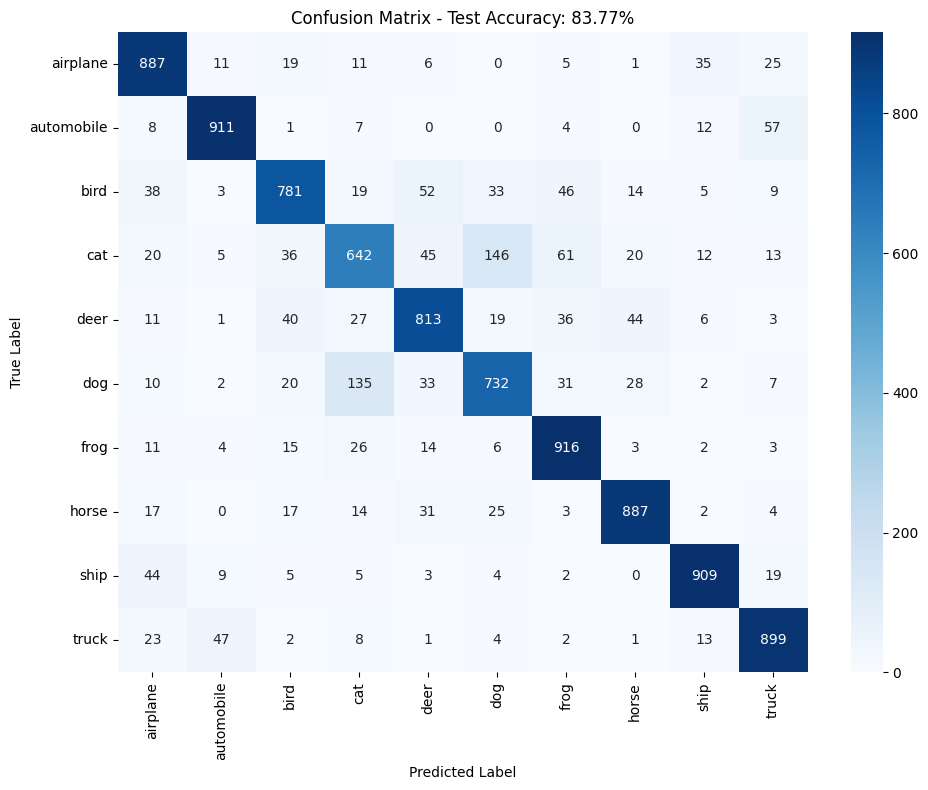


TRAINING SUMMARY
Total epochs trained: 200
Best validation accuracy: 84.56% (epoch 197)
Final test accuracy: 83.77%
Final test F1-score: 0.8363

Per-class accuracy:
  airplane    : 88.70%
  automobile  : 91.10%
  bird        : 78.10%
  cat         : 64.20%
  deer        : 81.30%
  dog         : 73.20%
  frog        : 91.60%
  horse       : 88.70%
  ship        : 90.90%
  truck       : 89.90%

 Training complete!


In [ ]:
# ============================================
# DEVICE SETUP
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", end="")
if torch.cuda.is_available():
    print(f" ({torch.cuda.get_device_name(device)})")
    print(f"Memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print()

# ============================================
# MODEL INITIALIZATION
# ============================================

print(f"\nInitializing Vision Transformer:")
print(f"  - Patches: {(img_size[0]//patch_size[0]) * (img_size[1]//patch_size[1])}")
print(f"  - Model dimension: {d_model}")
print(f"  - Heads: {n_heads}")
print(f"  - Layers: {n_layers}")
print(f"  - Parameters: ~{d_model * d_model * n_layers * 4 / 1e6:.1f}M (approx)")


transformer = VisionTransformer(
    d_model=d_model,
    n_classes=n_classes,
    img_size=img_size,
    patch_size=patch_size,
    n_channels=n_channels,
    n_heads=n_heads,
    n_layers=n_layers
).to(device)

# TOOL : to compute the number of parameters in the model
total_params = sum(p.numel() for p in transformer.parameters())
trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}") # The parameters where requires_grad=True


# ============================================
# OPTIMIZER & SCHEDULER
# ============================================

# A special scheduler is used. Adapted to Transformers training (improves generalisation, gradient convergence).
# During warmup : LR : 0 ──────▶ base_lr
# After Warmup : LR : base_lr ──────▶ ~0
# Decreasing function shape :
#    base_lr |╲
#            | ╲___
#            |     ╲___
#            |         ╲____
#         0  |______________╲___
#            warmup    →    end

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr_ratio=0.01):
    """
    Cosine schedule avec warmup et learning rate minimum
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))

        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(min_lr_ratio, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return LambdaLR(optimizer, lr_lambda)

# TODO : find justification the parameters
optimizer = AdamW(
    transformer.parameters(),
    lr=base_lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)

num_warmup_steps = warmup_epochs * len(train_loader)
num_training_steps = epochs * len(train_loader)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    min_lr_ratio=0.01  # means 1% of initial LR
)

# Loss with label smoothing
# y_smooth = (1 - α) × y_hard + α / K
# K=10 (number of classes)
# α=0.1 (label smoothing)

# Reduces Overconfidence / Overfitting / Extreme gradient values
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Mixed precision training
scaler = GradScaler()

# ============================================
# TRAINING UTILITIES
# ============================================

def train_epoch(model, loader, optimizer, criterion, scheduler, scaler, device):
    """ Function to train the model for 1 epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  # Used to compute confusion_matrix
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================
# VISUALIZATION SETUP
# ============================================

# Historique pour les graphiques
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Setup pour visualisation en temps réel
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Vision Transformer Training Progress', fontsize=14, fontweight='bold')

# Configuration des axes
ax_loss, ax_acc, ax_lr, ax_val = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# Loss plot
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Training & Validation Loss')
ax_loss.grid(True, alpha=0.3)

# Accuracy plot
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy (%)')
ax_acc.set_title('Training & Validation Accuracy')
ax_acc.grid(True, alpha=0.3)

# Learning rate plot
ax_lr.set_xlabel('Epoch')
ax_lr.set_ylabel('Learning Rate')
ax_lr.set_title('Learning Rate Schedule')
ax_lr.grid(True, alpha=0.3)
ax_lr.set_yscale('log')

# Validation comparison
ax_val.set_xlabel('Epoch')
ax_val.set_ylabel('Value')
ax_val.set_title('Overfitting Monitor (Train - Val)')
ax_val.grid(True, alpha=0.3)

# Lignes pour mise à jour
train_loss_line, = ax_loss.plot([], [], 'b-', label='Train', linewidth=2)
val_loss_line, = ax_loss.plot([], [], 'r-', label='Validation', linewidth=2)
train_acc_line, = ax_acc.plot([], [], 'b-', label='Train', linewidth=2)
val_acc_line, = ax_acc.plot([], [], 'r-', label='Validation', linewidth=2)
lr_line, = ax_lr.plot([], [], 'g-', linewidth=2)
overfit_line, = ax_val.plot([], [], 'purple', label='Loss Gap', linewidth=2)

# Légendes
ax_loss.legend(loc='upper right')
ax_acc.legend(loc='lower right')
ax_val.legend(loc='upper right')

plt.tight_layout()

# ============================================
# TRAINING LOOP
# ============================================

print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
early_stop_patience = 30

for epoch in range(1, epochs + 1):
    print(f"\n[Epoch {epoch}/{epochs}]")

    # Training
    train_loss, train_acc = train_epoch(
        transformer, train_loader, optimizer, criterion, scheduler, scaler, device
    )

    # Validation
    val_loss, val_acc, val_preds, val_labels = validate(
        transformer, val_loader, criterion, device
    )

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Check for best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, 'best_vit_model.pth')
        print(f" New best model saved! (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= early_stop_patience:
        print(f"\n Early stopping triggered after {epoch} epochs")
        print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
        break

    # Update plots
    if epoch % 1 == 0:  # Update every epoch
        epochs_range = range(1, len(history['train_loss']) + 1)

        train_loss_line.set_data(epochs_range, history['train_loss'])
        val_loss_line.set_data(epochs_range, history['val_loss'])
        train_acc_line.set_data(epochs_range, history['train_acc'])
        val_acc_line.set_data(epochs_range, history['val_acc'])
        lr_line.set_data(epochs_range, history['lr'])

        # Overfitting gap
        loss_gap = [t - v for t, v in zip(history['train_loss'], history['val_loss'])]
        overfit_line.set_data(epochs_range, loss_gap)

        # Adjust axes limits
        ax_loss.set_xlim(0, max(epoch + 1, 10))
        ax_loss.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

        ax_acc.set_xlim(0, max(epoch + 1, 10))
        ax_acc.set_ylim(0, 105)

        ax_lr.set_xlim(0, max(epoch + 1, 10))
        ax_lr.set_ylim(min(history['lr']) * 0.5, max(history['lr']) * 2)

        ax_val.set_xlim(0, max(epoch + 1, 10))
        if loss_gap:
            ax_val.set_ylim(min(loss_gap) * 1.2, max(loss_gap) * 1.2)



    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f'checkpoint_epoch_{epoch}.pth')

        for ax in [ax_loss, ax_acc, ax_lr, ax_val]:
          ax.relim()
          ax.autoscale_view()

        plt.draw()
        plt.pause(0.1)
plt.ioff()

# ============================================
# FINAL EVALUATION ON TEST SET
# ============================================

print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

# Load best model
checkpoint = torch.load('best_vit_model.pth')
transformer.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Test evaluation
test_loss, test_acc, test_preds, test_labels = validate(
    transformer, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='macro')
print(f"Macro F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2f}%')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# ============================================
# TRAINING SUMMARY
# ============================================

print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
print(f"Final test accuracy: {test_acc:.2f}%")
print(f"Final test F1-score: {f1:.4f}")

# Save final plots
fig.savefig('training_history.png', dpi=300)

# Performance par classe
print("\nPer-class accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = np.array(test_labels) == i
    class_acc = np.mean(np.array(test_preds)[class_mask] == i) * 100
    print(f"  {class_name:12s}: {class_acc:.2f}%")

print("\n Training complete!")